# CSV Profiles Generator for Rocket Nozzle Design

This notebook generates CSV files describing the geometric profiles of a rocket engine nozzle and its wall layers, including cooling channels. It is designed to help you quickly create and export nozzle geometry data for use in mesh generation, simulation, or further CAD processing.

---

## What Does This Notebook Do?

- **Defines nozzle and wall parameters:**  
  Set the main geometric parameters for the nozzle, wall thickness, and cooling channels.

- **Generates nozzle profiles:**  
  Uses Bézier and de Laval curves to create a smooth nozzle shape.

- **Calculates wall and channel layers:**  
  Computes the thickness and width of each layer (inner wall, cooling channel, outer wall) along the nozzle.

- **Exports to CSV:**  
  Saves the main nozzle curve and all layer data to two CSV files for easy use in other tools.

---

## How It Works

1. **Imports and Dependency Checks:**  
   The notebook checks for required Python packages (`numpy`, `matplotlib`, `scipy`, `pandas`, `math`) and installs them if missing.

2. **Parameter Setup:**  
   - Set the start, throat, and end positions and diameters of the nozzle.
   - Define wall thicknesses and cooling channel properties.
   - Choose the number of points for the profile and output CSV filenames.

3. **Profile Generation Functions:**  
   - Functions to create Bézier and de Laval curves for the nozzle profile.
   - Functions to calculate the thickness and width of each wall and channel layer.

4. **Profile and Layer Calculation:**  
   - Generates the main nozzle curve.
   - Calculates the thickness of each wall and channel layer at every point along the nozzle.
   - Computes the width and number of cooling channels.

5. **CSV Export:**  
   - Saves the nozzle curve (`nozzle_curve.csv`) with columns for x and y coordinates.
   - Saves the nozzle layers (`nozzle_layers.csv`) with columns for x, channel height, channel width, hot gas wall thickness, outer wall thickness, and number of channels.

6. **Visualization (Optional):**  
   - If `DEBUG = True`, plots the nozzle profile and wall layers for visual verification.

---

## How to Use

1. **Set your parameters** in the parameter cell (nozzle dimensions, wall thickness, channel properties).
2. **Run all cells** in order.
3. **Find your CSV files** (`nozzle_curve.csv` and `nozzle_layers.csv`) in the working directory.
4. **Use the CSV files** in your mesh generator, CAD tool, or simulation workflow.

---

## Example Output

- `nozzle_curve.csv`:  
  | x      | y      |
  |--------|--------|
  | ...    | ...    |

- `nozzle_layers.csv`:  
  | x      | channel height | channel width | hot gas wall | outer thickness | number channels |
  |--------|---------------|--------------|--------------|-----------------|-----------------|
  | ...    | ...           | ...          | ...          | ...             | ...             |

---

## Notes

- **Parameter validation:**  
  The notebook checks for negative wall thickness and warns you if your parameters are inconsistent.
- **Customization:**  
  You can easily adapt the parameters and functions for different nozzle shapes or channel designs.
- **Visualization:**  
  Enable `DEBUG = True` to see plots of the generated profiles and layers.


In [1]:
import os
import warnings
import time

try:
    import matplotlib.pyplot as plt
except ImportError:
    print("matplotlib is not installed. Trying to install it...")
    os.system("pip install matplotlib")
    import matplotlib.pyplot as plt

try:
    import numpy as np
except ImportError:
    print("numpy is not installed. Trying to install it...")
    os.system("pip install numpy")
    import numpy as np

try: 
    import scipy
    from scipy.optimize import linear_sum_assignment
    from scipy.sparse.csgraph import minimum_spanning_tree
except ImportError:
    print("scipy is not installed. Trying to install it...")
    os.system("pip install scipy")
    import scipy
    from scipy.optimize import linear_sum_assignment
    from scipy.sparse.csgraph import minimum_spanning_tree

try:
    import pandas as pd
except ImportError:
    print("pandas is not installed. Trying to install it...")
    %pip install pandas
    import pandas as pd

try:
    import math
except ImportError:
    print("math is not installed. Trying to install it...")
    %pip install math
    import math
    
try:
    import scipy.interpolate
except ImportError:
    print("scipy.interpolate is not installed. Trying to install it...")
    %pip install scipy
    import scipy.interpolate

In [2]:
### === Parameters for the nozzle ===

DEBUG = False

# Nozzle parameters
X_Start = 0.0  # Start of the nozzle in the x-direction
X_Throat = 1.0  # Throat of the nozzle in the x-direction
X_End = 3.0    # End of the nozzle in the x-direction
D_Start = 0.3  # Diameter at the start of the nozzle
D_Throat = 0.1  # Diameter at the throat of the nozzle
D_End = 1.0  # Diameter at the end of the nozzle
X_Nozzle_Parameters = [X_Start, X_Throat, X_End]
D_Nozzle_Parameters = [D_Start, D_Throat, D_End]
Nozzle_Wall_Thickness = 0.03  # Thickness of the nozzle wall

# Cooling channel parameters
Gaz_To_Cooling_Channel_Wall_Thickness = 0.01  # Distance from the gas to the cooling channel wall
Gaz_To_Cooling_Channel_Wall_Thickness_Function = lambda x: x*0 + Gaz_To_Cooling_Channel_Wall_Thickness # Function to get the thickness of the gas to cooling channel wall
Cooling_Channel_Thickness = 0.01  # Thickness of the cooling channel wall
Cooling_Channel_Thickness_Function = lambda x: x*0 + Cooling_Channel_Thickness  # Function to get the thickness of the cooling channel wall
Cooling_Channel_Number = 50 # Number of cooling channels
Cooling_Channel_Angle_Size = np.pi / 20 # Angle size of the cooling channel

# Outer wall parameter
Outer_Wall_Thickness = Nozzle_Wall_Thickness - Gaz_To_Cooling_Channel_Wall_Thickness - Cooling_Channel_Thickness  # Thickness of the outer wall
if Outer_Wall_Thickness < 0:
    warnings.warn("Outer wall thickness is negative. Adjust the parameters to ensure a valid design.")
    Outer_Wall_Thickness = 0.001  # Set to a minimum value to avoid negative thickness
Outer_Wall_Thickness_Function = lambda x: x*0 + Outer_Wall_Thickness  # Function to get the thickness of the outer wall

# Parameters of creation of the csv
number_of_points_profile = 200  # Number of points per profile
nozzle_curve_csv_filename = "nozzle_curve.csv" #You can add a folder name before the filename to save it in a specific folder
nozzle_curve_csv_columns = ["x", "y"]
nozzle_layers_csv_filename = "nozzle_layers.csv" #You can add a folder name before the filename to save it in a specific folder
nozzle_lavers_csv_columns = ["x","channel height","channel width","hot gas wall","outer thickness","number channels"]

In [3]:
### === Nozzle geometry functions === ###

def bezier(t, P0, P1, P2, P3):
    """Bézier curve function."""
    return (1 - t)**3 * P0 + 3 * (1 - t)**2 * t * P1 + 3 * (1 - t) * t**2 * P2 + t**3 * P3

def laval(x, XThroat, XExit, P0, P1, P2, P3, P4, P5, P6, P7):
    """Laval nozzle profile function."""
    if x < XThroat:
        t = x / XThroat
        return bezier(t, P0, P1, P2, P3)[1]
    else:
        t = (x - XThroat) / (XExit - XThroat)
        return bezier(t, P4, P5, P6, P7)[1]

def laval_curve_generator(X_vector, D_vector):
    """Generate the de Laval nozzle profile."""
    global number_of_points_profile
    
    XStart, XThroat, XExit = X_vector
    DStart, DThroat, DExit = D_vector
    
    # Bézier control points
    P0 = np.array([XStart, DStart / 2])
    P1 = np.array([XThroat, DStart / 2])
    P2 = np.array([XThroat, DThroat / 2])
    P3 = np.array([XStart, DThroat / 2])
    P4 = np.array([XThroat, DThroat / 2])
    P5 = np.array([XExit, (DThroat + DExit) / 4])
    P6 = np.array([XExit, DExit / 2])
    P7 = np.array([XThroat, DExit / 2])

    # Create the de Laval nozzle profile using Bézier curves
    print("Creating the de Laval nozzle profile...")
    X = np.linspace(XStart, XExit, number_of_points_profile)
    laval_curve = np.array([laval(x, XThroat, XExit, P0, P1, P2, P3, P4, P5, P6, P7) for x in X])
    
    return laval_curve

def create_profile(X_vector, D_vector, name="rocket_engine", debug=False):
    """Generate the rocket engine geometry. """
    
    # Create the de Laval nozzle profile using Bézier curves
    X = np.linspace(X_vector[0], X_vector[2], number_of_points_profile)
    laval_curve = laval_curve_generator(X_vector, D_vector)

    # Convert into a 2D array for plotting
    laval_curve_2D = [[X[i], laval_curve[i]] for i in range(len(laval_curve))]
    laval_curve_2D = np.array(laval_curve_2D)
    
    
    # Create the 2D inner and outer curves from the points
    curve = laval_curve_2D
    
    # Merge the inner and outer curve into one closed curve
    curve = np.array(curve)
    
    # Debug: Plot the nozzle profile
    if debug:
        plt.figure(figsize=(8, 4))
        plt.plot(curve[:, 0], curve[:, 1], label="Inner Curve", color='blue')
        plt.plot(curve[:, 0], curve[:, 1], label="Outer Curve", color='red')
        plt.fill_between(curve[:, 0], curve[:, 1], curve[:, 1], color='gray', alpha=0.5, label="Wall Thickness")
        plt.title(f"Profile of {name}")
        plt.xlabel("X-axis")
        plt.ylabel("Y-axis")
        plt.axhline(0, color='black', lw=0.5, ls='--')
        plt.axvline(0, color='black', lw=0.5, ls='--')
        plt.grid()
        plt.legend()
        plt.axis('equal')
        plt.show()
    
    return curve[:,1]

In [4]:
### === Profiles generator === ###

def generate_profiles(debug=False):
    """Generate the profiles for the rocket engine."""
    
    print("=== STARTING THE GENERATION OF THE PROFILES ===")

    #Get all the parameters
    global X_Nozzle_Parameters, D_Nozzle_Parameters, Nozzle_Wall_Thickness
    global Gaz_To_Cooling_Channel_Wall_Thickness_Function, Cooling_Channel_Thickness_Function, Outer_Wall_Thickness_Function
    global number_of_points_profile, inner_wall_csv_filename, geometry_csv_filename

    # Creating the x coordinates
    x_values = np.linspace(X_Nozzle_Parameters[0], X_Nozzle_Parameters[2], number_of_points_profile)
      
    print("=== GENERATING THE CURVE OF THE NOZZLE ===")
    gaz_wall_thickness = create_profile(X_Nozzle_Parameters, D_Nozzle_Parameters, name="gaz_wall", debug=debug)

    print("=== GENERATING THE FIRST LAYER OF THE NOZZLE WALL ===")
    gaz_to_cooling_channel_thickness = Gaz_To_Cooling_Channel_Wall_Thickness_Function(x_values)
    
    print("=== GENERATING THE THICKNESS OF THE COOLING CHANNEL WALL ===")
    cooling_channel_thickness = Cooling_Channel_Thickness_Function(x_values)
    
    print("=== GENERATING THE OUTER LAYER THICKNESS ===")
    outer_wall_thickness = Outer_Wall_Thickness_Function(x_values)
    
    # Debug: plot the cumulative thicknesses
    if debug:
        inner_nozzle = gaz_wall_thickness
        inner_cooling_channel = gaz_wall_thickness + gaz_to_cooling_channel_thickness
        outer_cooling_channel = inner_cooling_channel + cooling_channel_thickness
        outer_nozzle = outer_cooling_channel + outer_wall_thickness
        plt.figure(figsize=(10, 5))
        plt.plot(x_values, inner_nozzle, label="Inner Nozzle Wall", color='blue')
        plt.plot(x_values, inner_cooling_channel, label="Inner Cooling Channel", color='orange')
        plt.plot(x_values, outer_cooling_channel, label="Outer Cooling Channel", color='green')
        plt.plot(x_values, outer_nozzle, label="Outer Nozzle Wall", color='red')
        plt.title("Cumulative Thicknesses of the Nozzle")
        plt.xlabel("X-axis")
        plt.ylabel("Thickness")
        for i, x in enumerate(X_Nozzle_Parameters):
            plt.axvline(x, color='gray', lw=0.5, ls='--')
            plt.text(x, 0.1, f'X{i}', fontsize=8, verticalalignment='bottom', horizontalalignment='center')
        for i, d in enumerate(D_Nozzle_Parameters):
            plt.axhline(d, color='gray', lw=0.5, ls='--')
            plt.text(0.1, d, f'D{i}', fontsize=8, verticalalignment='center', horizontalalignment='right')
        plt.axhline(0, color='black', lw=0.5, ls='--')
        plt.axvline(0, color='black', lw=0.5, ls='--')
        plt.grid()
        plt.legend()
        plt.axis('equal')
        plt.show()
    
    print("=== GENERATING THE CHANNEL WIDTH ===")
    def angle_to_width(angle, radius):
        """Convert angle to width based on the radius."""
        return 2 * radius * np.sin(angle / 2)
    radius = gaz_to_cooling_channel_thickness + cooling_channel_thickness / 2 + outer_wall_thickness / 2
    cooling_channel_width = [angle_to_width(Cooling_Channel_Angle_Size, r) for r in radius]
    
    print("=== CREATING THE NUMBER OF COOLING CHANNELS ===")
    cooling_channel_number = [int(Cooling_Channel_Number) for x in x_values]
    
    print(f"=== CREATING FIRST FILE : {nozzle_curve_csv_filename} ===")
    # Create the nozzle curve CSV file using the specified columns
    nozzle_curve_data = {
        nozzle_curve_csv_columns[0]: x_values,
        nozzle_curve_csv_columns[1]: gaz_wall_thickness
    }
    nozzle_curve_df = pd.DataFrame(nozzle_curve_data)
    nozzle_curve_df.to_csv(nozzle_curve_csv_filename, index=False)
    
    print(f"=== CREATING SECOND FILE : {nozzle_layers_csv_filename} ===")
    # Create the nozzle layers CSV file using the specified columns
    nozzle_layers_data = {
        nozzle_lavers_csv_columns[0]: x_values,
        nozzle_lavers_csv_columns[1]: cooling_channel_thickness,
        nozzle_lavers_csv_columns[2]: cooling_channel_width,
        nozzle_lavers_csv_columns[3]: gaz_to_cooling_channel_thickness,
        nozzle_lavers_csv_columns[4]: outer_wall_thickness,
        nozzle_lavers_csv_columns[5]: cooling_channel_number
    }
    nozzle_layers_df = pd.DataFrame(nozzle_layers_data)
    nozzle_layers_df.to_csv(nozzle_layers_csv_filename, index=False)
    print("=== PROFILES GENERATED SUCCESSFULLY ===")
    return nozzle_curve_df, nozzle_layers_df


In [5]:
### === For visualisation purposes, the CSV extractor and visualizer === ###

global geometry_data

def csv_extractor(file_name_interior, file_name_walls, columns_names_interior, columns_names_walls):
    """
    This function extracts the geometry from a CSV file and returns the values as a dataframe.
    input: 
    file_name: names of the CSV files
    columns_names: list of column names to extract
    output: values: dataframes containing the values from the CSV file 
    """
    # Read the CSV file with specified column names
    # The first row is the header, so we need to skip it
    df_interior = pd.read_csv(file_name_interior, names=columns_names_interior, header=0)
    df_walls = pd.read_csv(file_name_walls, names=columns_names_walls, header=0)
    
    return df_interior, df_walls

def width_by_method(x, method, function, derivative, debug = False):
    if method == "ortho":
        return function(x)
    if method == "angle":
        # Calculate the angle using the derivative
        angle = math.atan(derivative(x))
        # Calculate the width using the angle
        y_factor = math.cos(angle)
        initial_width = function(x) * y_factor
        x_factor = math.sin(angle)
        x_used = x + x_factor* initial_width
        width = function(x_used) * y_factor
        if debug:
            return width, x_factor * initial_width
        return width

def geometry_creator(dataframe_interior, dataframe_wall, method, debug = False):
    """
    This function creates the geometry from the dataframe and returns the values as a list.
    input: 
    dataframe: dataframe containing the values from the CSV file
    method: method for the extraction of the geometry for the angle : "ortho" or "angle"
    output: values: list containing the values from the CSV file 
    """
    # Extract the values from the dataframe
    x_interior = dataframe_interior["x"].values
    y_interior = dataframe_interior["y"].values
    x_walls = dataframe_wall["x"].values
    channel_height = dataframe_wall["channel height"].values
    channel_width = dataframe_wall["channel width"].values
    hot_gas_wall = dataframe_wall["hot gas wall"].values
    outer_thickness = dataframe_wall["outer thickness"].values
    number_channels = dataframe_wall["number channels"].values

    # Interpolate functions for the different values
    interior_func = scipy.interpolate.interp1d(x_interior, y_interior, kind='linear', fill_value="extrapolate")
    channel_height_func = scipy.interpolate.interp1d(x_walls, channel_height, kind='linear', fill_value="extrapolate")
    channel_width_func = scipy.interpolate.interp1d(x_walls, channel_width, kind='linear', fill_value="extrapolate")
    hot_gas_wall_func = scipy.interpolate.interp1d(x_walls, hot_gas_wall, kind='linear', fill_value="extrapolate")
    outer_thickness_func = scipy.interpolate.interp1d(x_walls, outer_thickness, kind='linear', fill_value="extrapolate")
    number_channels_func = scipy.interpolate.interp1d(x_walls, number_channels, kind='linear', fill_value="extrapolate")
        
    # Calculate the derivatives of the functions to get their angles
    interior_derivative = np.gradient(interior_func(x_interior), x_interior)
    channel_height_derivative = np.gradient(channel_height_func(x_walls), x_walls)
    hot_gas_wall_derivative = np.gradient(hot_gas_wall_func(x_walls), x_walls)
    outer_thickness_derivative = np.gradient(outer_thickness_func(x_walls), x_walls)

    # Interpolate the derivatives to get the values at the same points as the functions
    interior_derivative = scipy.interpolate.interp1d(x_interior, interior_derivative, kind='linear', fill_value="extrapolate")
    channel_height_derivative = scipy.interpolate.interp1d(x_walls, channel_height_derivative, kind='linear', fill_value="extrapolate")
    hot_gas_wall_derivative = scipy.interpolate.interp1d(x_walls, hot_gas_wall_derivative, kind='linear', fill_value="extrapolate")
    outer_thickness_derivative = scipy.interpolate.interp1d(x_walls, outer_thickness_derivative, kind='linear', fill_value="extrapolate")
        
    # Create a new dataframe with the new values
    new_dataframe = pd.DataFrame(columns=["x", "nozzle inner wall", "nozzle outer wall", "channel inner wall", "channel outer wall", "channel width", "number channels"])
    for i,x in enumerate(x_interior):
        # We push x
        new_dataframe.loc[i, "x"] = x
        # First layer : the interior wall which is the first so the derivative is 0. We will jsut use the ortho method
        current_width = width_by_method(x, "ortho", interior_func, lambda x: 0)
        new_dataframe.loc[i, "nozzle inner wall"] = current_width
        # Second layer : the inner wall of the channel
        current_width = current_width +  width_by_method(x, method, hot_gas_wall_func, interior_derivative)
        new_dataframe.loc[i, "channel inner wall"] = current_width
        # Third layer : the outer wall of the channel
        current_width = current_width + width_by_method(x, method, channel_height_func, hot_gas_wall_derivative)
        new_dataframe.loc[i, "channel outer wall"] = current_width
        # Fourth layer : the outer wall of the channel
        current_width = current_width + width_by_method(x, method, outer_thickness_func, channel_height_derivative)
        new_dataframe.loc[i, "nozzle outer wall"] = current_width
        
        # Other values
        new_dataframe.loc[i, "channel width"] = channel_width_func(x)
        new_dataframe.loc[i, "number channels"] = int(number_channels_func(x))
    
    # Debug: plot the new values
    if debug:
        plt.plot(new_dataframe["x"], new_dataframe["nozzle inner wall"], label="nozzle inner wall")
        plt.plot(new_dataframe["x"], new_dataframe["nozzle outer wall"], label="nozzle outer wall")
        plt.plot(new_dataframe["x"], new_dataframe["channel inner wall"], label="channel inner wall")
        plt.plot(new_dataframe["x"], new_dataframe["channel outer wall"], label="channel outer wall")
        plt.xlabel("x")
        plt.ylabel("values")
        plt.title("New geometry values")
        plt.legend()
        plt.show()
        print(new_dataframe)
    
    return new_dataframe

def geometry_dataframe(file_name_interior, file_name_walls, columns_names_interior, columns_names_walls, method, debug = False, minimum_caracteristic_length = False):
    """
    This function creates the geometry from the dataframe and returns the values as a list.
    input: 
    file_name: names of the CSV files
    columns_names: list of column names to extract
    method: method for the extraction of the geometry for the angle : "ortho" or "angle"
    output: values: list containing the values from the CSV file 
    """
    # Extract the geometry from the CSV file
    values = csv_extractor(file_name_interior, file_name_walls, columns_names_interior, columns_names_walls)
    # Create the geometry
    geometry = geometry_creator(values[0], values[1], method)
    # Get the minimum caracteristic length
    if minimum_caracteristic_length:
        min_carac_length = min(min(values[1]["channel width"]), min(values[1]["channel height"]), min(values[1]["outer thickness"]), min(values[1]["hot gas wall"]))
        return geometry, min_carac_length
    return geometry

    
    
def define_profiles_from_CSV():
    global geometry_data
    # We define the different profiles
    global Nozzle_Profile_Inner, Nozzle_Profile_Outer
    global Channel_Profile_Inner, Channel_Profile_Outer
    global Channel_Angle_Size, Channel_Number
    global Channel_Angle_Size_Mean
    global Radius_Study_Margin 
    global Center_Profile, Exterior_Profile
    global Channel_Width
    global Channel_Number
    
    # Specirfy the Radius Study Margin
    Radius_Study_Margin = 0.02  # Margin to ensure the exterior profile is outside the nozzle outer wall
    
    # Get the data
    x = geometry_data["x"]
    y_nozzle_inner = geometry_data["nozzle inner wall"].astype(float).values
    y_nozzle_outer = geometry_data["nozzle outer wall"].astype(float).values
    y_channel_inner = geometry_data["channel inner wall"].astype(float).values
    y_channel_outer = geometry_data["channel outer wall"].astype(float).values
    y_channel_width = geometry_data["channel width"].astype(float).values
    y_channel_number = geometry_data["number channels"].astype(float).values
    
    # We create the exterior limit profile via the max outside profile and the Radius Study Margin
    y_exterior = np.full_like(x, np.max(y_nozzle_outer) + Radius_Study_Margin)
    
    #We create the center profile as a profile of height 0
    y_center= np.zeros_like(x)
    
    # Create the profiles
    Nozzle_Profile_Inner = np.array([x[::-1], y_nozzle_inner[::-1]]).T
    Nozzle_Profile_Outer = np.array([x, y_nozzle_outer]).T
    Channel_Profile_Inner = np.array([x[::-1], y_channel_inner[::-1]]).T
    Channel_Profile_Outer = np.array([x, y_channel_outer]).T
    Center_Profile = np.array([x, y_center]).T
    Exterior_Profile = np.array([x, y_exterior]).T
    
    # Define the channel angle size and channel number
    Channel_Angle_Size = [y_channel_width[i] / np.mean([y_channel_inner[i], y_channel_outer[i]]) for i in range(len(x))]
    Channel_Angle_Size_Mean = np.mean(Channel_Angle_Size)
    Channel_Number = int(np.mean(y_channel_number))
    Channel_Width = np.array([x, y_channel_width]).T
    Channel_Angle_Size = np.mean(Channel_Angle_Size)  # Use the mean value for the channel angle size
    
    print(Channel_Number)
    
    return True

def plot_profiles(nozzle=False, channel=False):

    # Get the profiles
    global Nozzle_Profile_Inner, Nozzle_Profile_Outer
    global Channel_Profile_Inner, Channel_Profile_Outer
    global Center_Profile, Exterior_Profile
    
    # Plot the profiles
    plt.figure()
    plt.plot(Nozzle_Profile_Inner[:, 0], Nozzle_Profile_Inner[:, 1], label="Nozzle Inner Profile", color='blue')
    plt.plot(Nozzle_Profile_Outer[:, 0], Nozzle_Profile_Outer[:, 1], label="Nozzle Outer Profile", color='red')
    plt.plot(Channel_Profile_Inner[:, 0], Channel_Profile_Inner[:, 1], label="Channel Inner Profile", color='green')
    plt.plot(Channel_Profile_Outer[:, 0], Channel_Profile_Outer[:, 1], label="Channel Outer Profile", color='orange')
    plt.plot(Center_Profile[:, 0], Center_Profile[:, 1], label="Center Profile", color='black', linestyle='--')
    plt.plot(Exterior_Profile[:, 0], Exterior_Profile[:, 1], label="Exterior Profile", color='gray', linestyle='--')
    plt.title("Profiles of the Rocket Engine")
    plt.xlabel("X-axis")
    plt.ylabel("Y-axis")
    plt.axhline(0, color='black', lw=0.5, ls='--')
    plt.axvline(0, color='black', lw=0.5, ls='--')
    plt.grid()
    plt.legend()
    plt.show()

    # Add independent plots for nozzle and channel
    if nozzle:
        plt.figure()
        plt.plot(Nozzle_Profile_Inner[:, 0], Nozzle_Profile_Inner[:, 1], label="Nozzle Inner Profile", color='blue')
        plt.plot(Nozzle_Profile_Outer[:, 0], Nozzle_Profile_Outer[:, 1], label="Nozzle Outer Profile", color='red')
        plt.plot(Center_Profile[:, 0], Center_Profile[:, 1], label="Center Profile", color='black', linestyle='--')
        plt.plot(Exterior_Profile[:, 0], Exterior_Profile[:, 1], label="Exterior Profile", color='gray', linestyle='--')
        plt.title("Nozzle Profiles")
        plt.xlabel("X-axis")
        plt.ylabel("Y-axis")
        plt.axhline(0, color='black', lw=0.5, ls='--')
        plt.axvline(0, color='black', lw=0.5, ls='--')
        plt.grid()
        plt.legend()
        plt.axis('equal')
        plt.show()
    if channel:
        plt.figure()
        plt.plot(Channel_Profile_Inner[:, 0], Channel_Profile_Inner[:, 1], label="Channel Inner Profile", color='green')
        plt.plot(Channel_Profile_Outer[:, 0], Channel_Profile_Outer[:, 1], label="Channel Outer Profile", color='orange')
        plt.title("Channel Profiles")
        plt.xlabel("X-axis")
        plt.ylabel("Y-axis")
        plt.axhline(0, color='black', lw=0.5, ls='--')
        plt.axvline(0, color='black', lw=0.5, ls='--')
        plt.grid()
        plt.legend()
        plt.axis('equal')
        plt.show()

        # Add a circular plot showing all the possible channels with the angle size
        plt.figure()
        angle_positions = np.linspace(0, 2 * np.pi, Channel_Number, endpoint=False)
        for i in range(Channel_Number):
            start_angle = angle_positions[i]
            # Draw the sector for each channel
            points = np.array([
                (np.cos(start_angle + a), np.sin(start_angle + a))
                for a in np.linspace(0, Channel_Angle_Size_Mean, 100)
            ])
            plt.plot(points[:, 0], points[:, 1], color='green', alpha=0.5)
        plt.title("Channel Angle Positions")
        plt.xlabel("X-axis")
        plt.ylabel("Y-axis")
        plt.axhline(0, color='black', lw=0.5, ls='--')
        plt.axvline(0, color='black', lw=0.5, ls='--')
        plt.grid()
        plt.axis('equal')
        plt.show()
    
    return True
    
    
def debug_profiles():
    """Create the profiles of the rocket engine."""
    
    #Extract the profiles from the CSV file
    global geometry_data
    geometry_data, min_carac_length = geometry_dataframe(nozzle_curve_csv_filename, nozzle_layers_csv_filename, nozzle_curve_csv_columns, nozzle_lavers_csv_columns, method="angle", debug=DEBUG, minimum_caracteristic_length=True)
    
    # Define the profiles from the CSV file
    define_profiles_from_CSV()
    print("Profiles defined from CSV file.")
    
    # Plot the profiles
    plot_profiles(nozzle=True, channel=True)
    
    return True



=== STARTING THE GENERATION OF THE PROFILES ===
=== GENERATING THE CURVE OF THE NOZZLE ===
Creating the de Laval nozzle profile...
=== GENERATING THE FIRST LAYER OF THE NOZZLE WALL ===
=== GENERATING THE THICKNESS OF THE COOLING CHANNEL WALL ===
=== GENERATING THE OUTER LAYER THICKNESS ===
=== GENERATING THE CHANNEL WIDTH ===
=== CREATING THE NUMBER OF COOLING CHANNELS ===
=== CREATING FIRST FILE : nozzle_curve.csv ===
=== CREATING SECOND FILE : nozzle_layers.csv ===
=== PROFILES GENERATED SUCCESSFULLY ===
Profiles generated in 0.01 seconds.
Nozzle curve saved to nozzle_curve.csv
Nozzle layers saved to nozzle_layers.csv
=== END OF THE SCRIPT ===
=== DEBUGGING THE PROFILES ===
50
Profiles defined from CSV file.


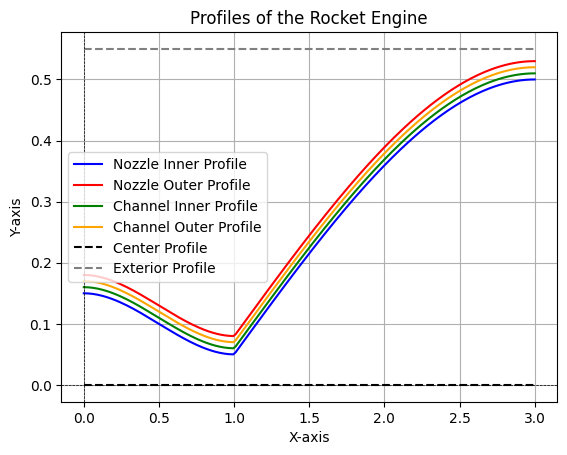

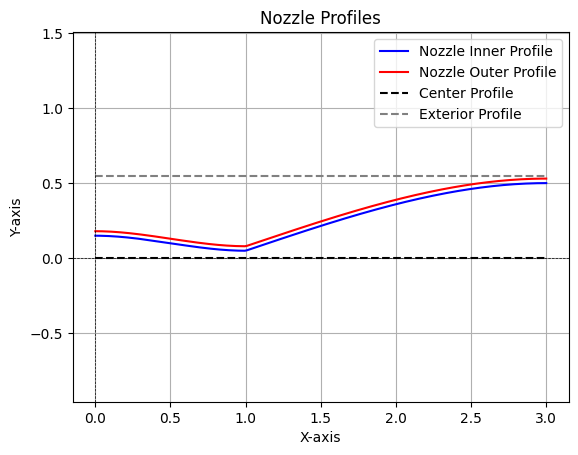

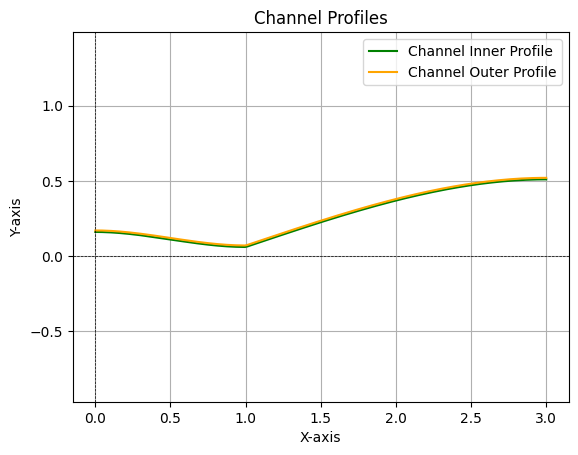

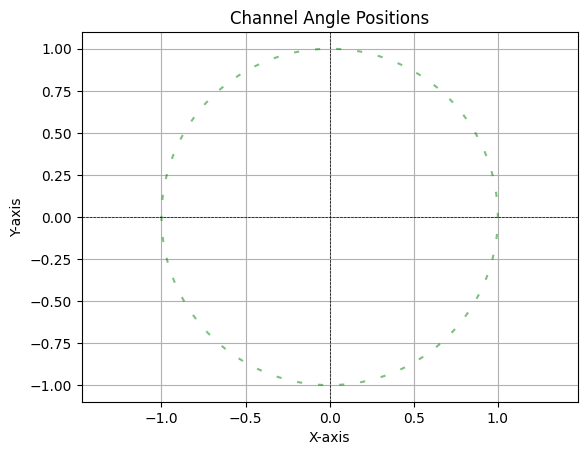

=== PROFILES DEBUGGED SUCCESSFULLY ===
=== END OF THE DEBUGGING ===


In [6]:
### === Main function to run the script === ###

if __name__ == "__main__":
    start_time = time.time()
    nozzle_curve_df, nozzle_layers_df = generate_profiles(debug=DEBUG)
    end_time = time.time()
    
    print(f"Profiles generated in {end_time - start_time:.2f} seconds.")
    print(f"Nozzle curve saved to {nozzle_curve_csv_filename}")
    print(f"Nozzle layers saved to {nozzle_layers_csv_filename}")
    print("=== END OF THE SCRIPT ===")
    
    print("=== DEBUGGING THE PROFILES ===")
    debug_profiles()
    print("=== PROFILES DEBUGGED SUCCESSFULLY ===")
    print("=== END OF THE DEBUGGING ===")